In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')
path_basic = 'drive/My Drive/face-swap'
os.chdir(path_basic)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import PIL.Image as Image
from tqdm import tqdm_notebook
import glob


import torch
import torch.nn.functional as F
from torchvision import transforms as trans

from face_modules.mtcnn import MTCNN
from face_modules.model import Backbone, Arcface, MobileFaceNet, Am_softmax, l2_norm

In [ ]:
device = torch.device('cuda')
arcface = Backbone(50, 0.6, 'ir_se').to(device)
arcface.eval()
arcface.load_state_dict(torch.load('./face_modules/models/model_ir_se50.pth', 
                                   map_location=device), strict=False)

<All keys matched successfully>

In [ ]:
test_transform = trans.Compose([
    trans.ToTensor(),
    trans.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
root_dir = 'data_mtcnn'
test_path = os.path.join(root_dir, '00031365.png')
import pickle
if os.path.exists('train_pathes.pickle'):
  with open('train_pathes.pickle', 'rb') as f:
    train_pathes = pickle.load(f)
  with open('val_pathes.pickle', 'rb') as f:
    test_pathes = pickle.load(f)
all_pathes = train_pathes + test_pathes

In [ ]:
root_vgg_face = 'vgg_face_mtcnn'
folders_vgg = glob.glob(os.path.join(root_vgg_face, '*'))[:10]
pathes_vgg = {}
for folder in folders_vgg:
  pathes_vgg[folder] = glob.glob(os.path.join(folder, '*.png'))

In [ ]:
os.listdir(root_dir)

In [ ]:
test_path= pathes_vgg[folders_vgg[0]][0]
test_img_rgb = test_transform(Image.open(test_path).resize((112,112), Image.ANTIALIAS)).unsqueeze(0).cuda()
test_img_bgr = test_transform(Image.fromarray(cv2.imread(test_path)).resize((112,112), Image.ANTIALIAS)).unsqueeze(0).cuda()
with torch.no_grad():
  emb_test_rgb,_ = arcface(test_img_rgb)
  emb_test_bgr,_ = arcface(test_img_bgr)

In [ ]:
emb_test_rgb = emb_test_rgb.cpu().numpy().squeeze()
emb_test_bgr = emb_test_bgr.cpu().numpy().squeeze()
emb_test_bgr.shape, emb_test_rgb.shape

((512,), (512,))

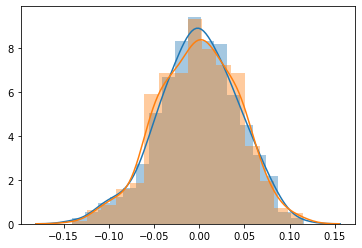

In [ ]:
sns.distplot(emb_test_rgb)
sns.distplot(emb_test_bgr)

### Check the distributions

In [ ]:
def compute_similarity(batch_embs, emb_test):
  distances = torch.cosine_similarity(emb_test, batch_embs).cpu().numpy()
  return distances

def imread(path, rgb=True):
  if rgb:
    img = test_transform(Image.open(path).resize((112,112), Image.ANTIALIAS)).unsqueeze(0).cuda()
    return img
  img = test_transform(Image.fromarray(cv2.imread(path)).resize((112,112), Image.ANTIALIAS)).unsqueeze(0).cuda()
  return img

In [ ]:
# compare similarities with own images
similarities_own = []

for folder in tqdm_notebook(folders_vgg, total=len(folders_vgg)):
  test_folder = folder
  pathes_test = pathes_vgg[test_folder]
  idx_test = 1

  test_img = imread(pathes_test[idx_test], rgb=True)
  with torch.no_grad():
      test_emb, _ = arcface(test_img)
  
  BATCH_SIZE=64 if len(pathes_test) >= 64 else len(pathes_test)
  NUM_ITER = len(pathes_test) // BATCH_SIZE
  NUM_RESID = len(pathes_test) % BATCH_SIZE

  for i in tqdm_notebook(range(NUM_ITER)):
    pathes = pathes_test[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    imgs = torch.cat([imread(path, rgb=True) for path in pathes])
    with torch.no_grad():
      embs, _ = arcface(imgs)
    sims = compute_similarity(embs, test_emb)
    similarities_own.extend(sims.tolist())


  pathes = pathes_test[-NUM_RESID:]
  imgs = torch.cat([imread(path, rgb=True) for path in pathes])
  with torch.no_grad():
    embs, _ = arcface(imgs)
  sims = compute_similarity(embs, test_emb)
  similarities_own.extend(sims.tolist())

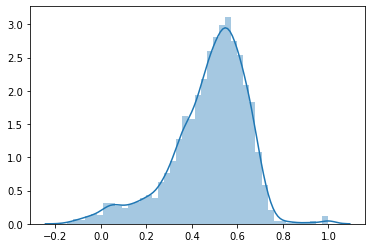

In [ ]:
sns.distplot(similarities_own)

In [ ]:
# compare similarities with other images
similarities_others = []
for folder in tqdm_notebook(folders_vgg, total=len(folders_vgg)):
  test_folder = folder
  idx_test = 1
  pathes_test = pathes_vgg[test_folder]
  test_img = imread(pathes_test[idx_test], rgb=True)
  with torch.no_grad():
      test_emb, _ = arcface(test_img)

  pathes_others = []
  for key, values in pathes_vgg.items():
    if key != test_folder:
      pathes_others.extend(values)

  BATCH_SIZE=64 if len(pathes_test) >= 64 else len(pathes_test)
  NUM_ITER = len(pathes_others) // BATCH_SIZE
  NUM_RESID = len(pathes_others) % BATCH_SIZE

  for i in tqdm_notebook(range(NUM_ITER)):
    pathes = pathes_others[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    imgs = torch.cat([imread(path, rgb=True) for path in pathes])
    with torch.no_grad():
      embs, _ = arcface(imgs)
    sims = compute_similarity(embs, test_emb)
    similarities_others.extend(sims.tolist())

  if NUM_RESID > 0:
    pathes = pathes_others[-NUM_RESID:]
    imgs = torch.cat([imread(path, rgb=True) for path in pathes])
    with torch.no_grad():
      embs, _ = arcface(imgs)
    sims = compute_similarity(embs, test_emb)
    similarities_others.extend(sims.tolist())

In [ ]:
len(similarities_others)

27549

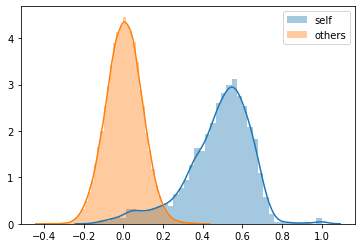

In [ ]:
sns.distplot(similarities_own, label='self')
sns.distplot(similarities_others, label='others');
plt.legend();

#### Search similar by embeddings

In [ ]:
BATCH_SIZE=128
NUM_ITER = len(all_pathes) // BATCH_SIZE
NUM_RESID = len(all_pathes) % BATCH_SIZE
similarities = []

for i in tqdm_notebook(range(NUM_ITER), total=NUM_ITER):
  pathes = all_pathes[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
  imgs = torch.cat([imread(path) for path in pathes])
  with torch.no_grad():
    embs, _ = arcface(imgs)
  sims = compute_similarity(embs)
  similarities.extend(sims)

similarities_arr = np.array(similarities)

In [ ]:
similarities

In [ ]:
pathes_use = all_pathes[:len(similarities)]
pathes_sims = zip(pathes_use, similarities)
pathes_sims = sorted(pathes_sims, key=lambda x: x[1], reverse=True)

In [ ]:
top_K_pathes = pathes_sims[:5]
init_img = plt.imread(test_path)
top_K_imgs = []
for path, score in top_K_pathes:
  top_K_imgs.append(plt.imread(path))

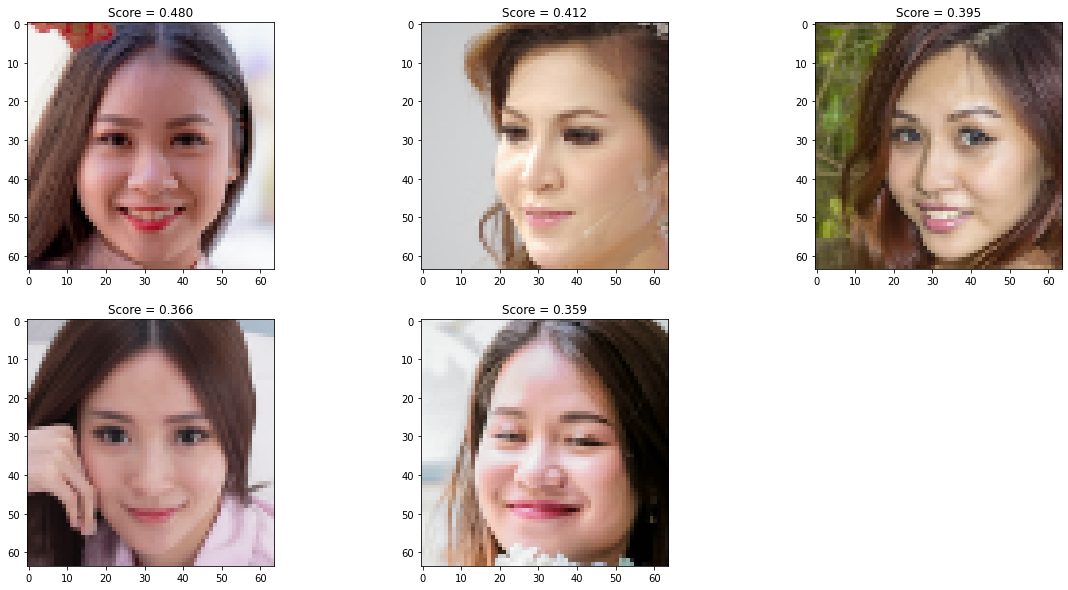

In [ ]:
plt.subplots(figsize=(20,10))
for i,img in enumerate(top_K_imgs):

  plt.subplot(2, 3, i+1)
  plt.title(f"Score = {top_K_pathes[i][1]:.3f}")
  plt.imshow(img)

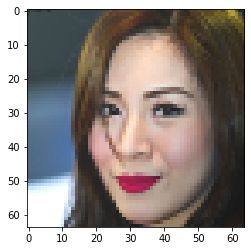

In [ ]:
plt.imshow(init_img)